# TTD list
1. Verify type of vars (continuous and discrete features) - <span style="color:green"> **DONE**</span>
2. Identify vars with NaNs - <span style="color:green"> **DONE**</span>
3. Decide what to do with NaNs, read doc again about this - <span style="color:green"> **DONE**</span>
    - Geography - 17 NAs remove
    - Balance - 20 NAs remove
    - Marketing12m - 6,077 NAs
4. Encode vars with string labels like 'Tenure'- <span style="color:green"> **DONE**</span>
    - tenure -1 and "New" = 0
    - tenure 101 and 674 - remove these 2 cases
5. Change Marketing variable into categorical - so missing will turn into another category <span style="color:green"> **DONE**</span>
6. Change and relabel Geography into integers for categorical <span style="color:green"> **DONE**</span>
7. Plots of some of the variables - <span style="color:green"> **DONE**</span>
    - plots f Balance, Age and Number of products against Exited <span style="color:green"> **DONE**</span>
    - add Imbalanced target plot <span style="color:green"> **DONE**</span>
    - add comments on plots <span style="color:green"> **DONE**</span>
8. Run classifier and hyperparameter tunning - <span style="color:green"> **DONE**</span>
9. Check DC article and look for another example - <span style="color:green"> **DONE**</span>
10. Think of justification for RF. Is it the most straightforward to try? - <span style="color:green"> **DONE**</span>
11. Add other methods I could have used (for next steps bullet points) and understand them a bit - <span style="color:green"> **DONE**</span>
12. Tidy up notebook and write conclusions and steps I went through - <span style="color:green"> **DONE**</span>
13. refresh on MBA and Power Analysys before interview - <span style="color:orange"> **ON GOING**</span>

[comment]: <> (<span style="color:orange"> **ON GOING**</span>)
[comment]: <> (<span style="color:red"> **NOT DONE**</span>)
[comment]: <> (<span style="color:green"> **DONE**</span>)
[comment]: <> (<span style="color:fuchsia"> **TO DO**</span>)


# Bank leavers analysis - Tesco Bank interview

Applicant: Rocio Martinez<br>
Date: May 2023

### Introduction 

**What is a Random Forest?**<br>
RF is an ensemble method that can be used for classification problems like this one. It is an ensemble method because it trains a number of decision trees and takes the majority voted prediction of these as a prediction for a new example or experiment. In this case, the prediction needed is a binary classification: 'left the bank' and 'not left the bank'.<br>
<br>
**Why using a RF?**<br>
It is a good methodology because:
- Decision trees accept both continuous and discrete features, which fits well in this case. 
- It is quite straightforward and scikit learn has a RF classifier in place which makes things easier
- The results and methodology are friendly, i.e., they are usually easy to interpret, explain and understand

### Analysis' steps
1. Input data
    - Reading the data
    - Data cleansing
2. Looking at the data - plotting and tables
3. Random Forest classifier
    - RF pipeline
    - Accuracy of one RF model
    - Hyperparameter Tuning
    - Performance
    - Feature Importance
4. Next steps
5. Final thoughts

In [140]:
# Data Processing
import pandas as pd
import numpy as np
import datetime

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectPercentile, chi2

## 1. Input data

### 1.1 Reading the data

In [218]:
raw_data=pd.read_csv('Modelling Task Data - Tesco Bank.csv')
raw_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,HasClaimed,NumOfProducts,HasCrCard,IsMember,Marketing12m,Salary,Exited
0,1,15634602,Hargrave,619,geo1,Female,42,2,0.00,0,1,1,1,NaN,101348.88,1
1,2,15647311,Hill,608,geo2,Female,41,1,83807.86,0,1,0,1,NaN,112542.58,0
2,3,15619304,Onio,502,geo1,Female,42,8,159660.80,0,3,1,0,NaN,113931.57,1
3,4,15701354,Boni,699,geo1,Female,39,1,0.00,0,2,0,0,NaN,93826.63,0
4,5,15737888,Mitchell,850,geo2,Female,43,2,125510.82,0,1,1,1,0.0,79084.10,0


In [81]:
def vars_description(*columns: str):
    def pipe(df: pd.DataFrame):
        subset_df = df[list(columns)] if len(columns) > 0 else df
        summary = subset_df.describe(include="all").T
        d_types = subset_df.dtypes
        nas = pd.DataFrame({
            "num_na": subset_df.isnull().sum()
        })
        summary = pd.concat([summary, d_types, nas], axis="columns")
        summary.rename(columns = {'count':'non_null',0:'var_type'}, inplace = True)
        return summary
    return pipe

In [82]:
raw_data.pipe(vars_description())

,non_null,unique,top,freq,mean,std,min,25%,50%,75%,max,var_type,num_na
RowNumber,10000.0,NaN,NaN,NaN,5000.5,2886.89568,1.0,2500.75,5000.5,7500.25,10000.0,int64,0
CustomerId,10000.0,NaN,NaN,NaN,15690940.5694,71936.186123,15565701.0,15628528.25,15690738.0,15753233.75,15815690.0,int64,0
Surname,10000,2932,Smith,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object,0
CreditScore,10000.0,NaN,NaN,NaN,650.5288,96.653299,350.0,584.0,652.0,718.0,850.0,int64,0
Geography,9983,3,geo1,5007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object,17
Gender,10000,2,Male,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object,0
Age,10000.0,NaN,NaN,NaN,38.9218,10.487806,18.0,32.0,37.0,44.0,92.0,int64,0
Tenure,10000,15,2,1044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object,0
Balance,9980.0,NaN,NaN,NaN,76479.923661,62409.050922,0.0,0.0,97198.54,127644.24,250898.09,float64,20
HasClaimed,10000.0,NaN,NaN,NaN,0.0506,0.21919,0.0,0.0,0.0,0.0,1.0,int64,0


From looking at the table, one can see the data is quite clean. Few thing that need to be checked, cleaned and modifiy include:

- Tenure check, data type = object meaning there is a mix of strings and numbers and it should be integers only
- Geography. There are 17 cases with NAs to be removed and variable to be changed to categorical (the latter will be added as part of the preprocessing in the RF pipeline in section 3)
- Balance - There are 20 cases with NAs to be removed
- Marketing12m - change variable into categorical with NANs to be turned into a new category. (Meaning, 1: they responded, 0:not responded, 2:did not receive marketing comms), this will be added as part of the preprocessing in the RF pipeline in section 3


### 1.2 Data cleansing

#### 🔹Tenure - labels and data type change

In [23]:
pd.crosstab(raw_data.Exited, raw_data.Tenure)
# tenure -1 and "New" = 0
# tenure 101 and 674 - remove 

Tenure,-1,0,1,10,101,2,3,4,5,6,674,7,8,9,New
Exited,,,,,,,,,,,,,,,
0,10,318,802,389,0,843,793,785,801,770,1,851,827,771,2
1,1,94,232,101,1,201,213,202,209,195,0,177,197,213,1


In [80]:
# needed to also change data type to int as some of the labels were not really numbers but strings
df_modifiedvars=raw_data.assign(
    new_tenure=raw_data.Tenure.replace('New', 0).astype(int).replace(-1, 0)
)
pd.crosstab(df_modifiedvars.Exited, df_modifiedvars.new_tenure)

new_tenure,0,1,2,3,4,5,6,7,8,9,10,101,674
Exited,,,,,,,,,,,,,
0,330,802,843,793,785,801,770,851,827,771,389,0,1
1,96,232,201,213,202,209,195,177,197,213,101,1,0


#### 🔹Dropping NAs and Marketing variable change

Changes to do:
- Geography - 17 cases with NAs remove
- Balance - 20 cases with NAs remove
- new_tenure = 101 and 674 - remove 2 cases
- change Marketing NANs to number 2 so that the new variable will be: 1 = yes they responded, 0 = no they didn’t respond, 2 = they did not receive a marketing communication in this time


In [267]:
df_removedNAs=df_modifiedvars.dropna(subset = ['Geography','Balance'])
df_remove_tenurecases=df_removedNAs.drop(df_removedNAs[(df_removedNAs.new_tenure==101)|(df_removedNAs.new_tenure==674)].index)
df_marketingchange=df_remove_tenurecases.fillna(value={'Marketing12m':2})
df_readyforRFpipe=df_marketingchange

In [268]:
df_readyforRFpipe.pipe(vars_description())

,non_null,unique,top,freq,mean,std,min,25%,50%,75%,max,var_type,num_na
RowNumber,9961.0,NaN,NaN,NaN,5005.03845,2886.927546,1.0,2505.0,5008.0,7506.0,10000.0,int64,0
CustomerId,9961.0,NaN,NaN,NaN,15690993.250176,71925.598584,15565701.0,15628674.0,15690744.0,15753337.0,15815690.0,int64,0
Surname,9961,2926,Smith,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object,0
CreditScore,9961.0,NaN,NaN,NaN,650.511796,96.603813,350.0,584.0,652.0,717.0,850.0,int64,0
Geography,9961,3,geo1,4998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object,0
Gender,9961,2,Male,5431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object,0
Age,9961.0,NaN,NaN,NaN,38.93324,10.493661,18.0,32.0,37.0,44.0,92.0,int64,0
Tenure,9961,13,2,1041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object,0
Balance,9961.0,NaN,NaN,NaN,76422.938437,62410.725392,0.0,0.0,97086.4,127637.92,250898.09,float64,0
HasClaimed,9961.0,NaN,NaN,NaN,0.050497,0.218979,0.0,0.0,0.0,0.0,1.0,int64,0


#### 🔹Checking Geography values


In [271]:
df_readyforRFpipe.Geography.unique()

array(['geo1', 'geo2', 'geo3'], dtype=object)

This variable will be one-hot encoded in the classifier, meaning it will be transformed from 1 variable to 3 flags

## 2. Looking at the data - plotting and tables

#### 🔹 Input variable - Age

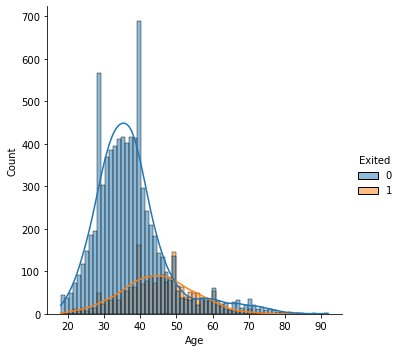

In [272]:
sns.displot(df_readyforRFpipe,x='Age',hue="Exited",kde=True,rug=False)

In [294]:
df_readyforRFpipe[['Age','Exited']].groupby(by="Exited").agg({'Age':['mean', 'median']})

Age       
             mean median
Exited                  
0       37.417602   36.0
1       44.854680   45.0

**Highlights**:
- From the graph and table, the average and median are very similar, with age of bank leavers is 45 years old and 37 years old for the ones that stay. 
- It is also interesting to notice that, from age 60+ most of the customers decide to stay with the bank. 

#### 🔹 Input variable - Balance

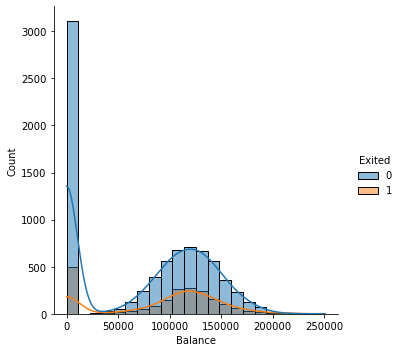

In [273]:
sns.displot(df_readyforRFpipe,x='Balance',hue="Exited",kde=True,rug=False)

In [296]:
df_balance=df_readyforRFpipe[['Balance','Exited']]
df_balance[df_balance['Balance']>0].groupby(by="Exited").agg({'Balance':['mean', 'median']})

Balance            
                 mean      median
Exited                           
0       119533.743454  119794.670
1       120743.558882  119918.965

**Highlights**:
- Balance amounts when > 0 are nicely distributed following a bell shape. 
- The mean and the median for this bell-shaped subset is again quite similar with an avg of £119,533.7 for customer that do no leave and £120,743.5 for the ones that do. 
- There are 3,500 customer that seemed to have balace 0 and would be of interest to investigate further this. For example, if this data is accurate or what kind of accounts this balance come from. 

#### 🔹 Input variable - Number of products

<AxesSubplot: xlabel='NumOfProducts', ylabel='count'>

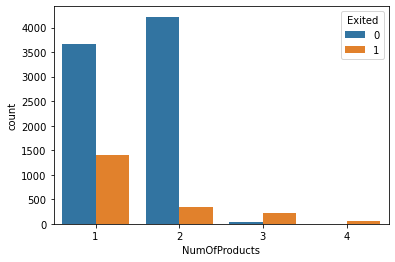

In [274]:
sns.countplot(data=df_readyforRFpipe, x="NumOfProducts", hue="Exited")

In [318]:
#sns.displot(df_readyforRFpipe,x='Balance',hue="NumOfProducts",col='Exited',kde=True,rug=False)

In [299]:
df_balance_prods=df_readyforRFpipe[['Balance','NumOfProducts','Exited']]
df_balance_prods[df_balance_prods['Balance']>0].groupby(['NumOfProducts','Exited']).agg({'Balance':['mean', 'median']})

Balance            
                               mean      median
NumOfProducts Exited                           
1             0       119478.796668  119688.810
              1       121055.707816  120392.990
2             0       119639.379522  120022.920
              1       119920.994556  118210.420
3             0       118423.614000  127221.575
              1       119542.273165  117927.680
4             1       122260.610870  120968.270

**Highlights**:
- The vast mayority of customers have between 1 and 2 products.
- For 3 and 4 products the proportions of leavers and not leavers switch, i.e., the leavers have usually 3 or 4 products
- As fo the mean and the median of the balance in the number of products, the numbers don't seem to differ a lot again between this 2 metrics. And they also dont differ a lot between the number of products and the Exited variable. I do wonder if from the start, the Balance in the data is for all products a customer has or if it is already an average of the products balances. This relationshilp would also be good to investigate and understand further to have a better picture of what happens to the balance in the previous weeks or months before a person decides to leave.

#### 🔹 Target variable - Exited

<AxesSubplot: xlabel='Exited', ylabel='count'>

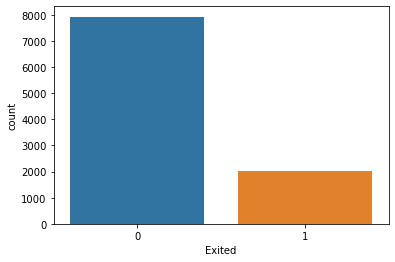

In [276]:
sns.countplot(data=df_readyforRFpipe, x="Exited")

**Highlights**:
- The target variable 'Exited' is imbalanced, meaning, it presents a lot more 0s (did not leave the bank) than 1s (left the bank). 
- This will be address in the RF pipeline as part of the classifier parmeters where soem weighs will be added to the variable depending if it is a 1 or a 0. A further note about this can be found bellow. 

## 3. Random Forest classifier

### 3.1 RF pipeline

In [320]:
# Variables to be used in the RF pipeline
bank_data = df_readyforRFpipe[[
    'CreditScore',
    'Geography',
    'Gender',
    'Age',
    'new_tenure',
    'Balance',
    'HasClaimed',
    'NumOfProducts',
    'HasCrCard',
    'IsMember',
    'Salary',
    'Marketing12m',
    'Exited',
]]
bank_data.head()

,CreditScore,Geography,Gender,Age,new_tenure,Balance,HasClaimed,NumOfProducts,HasCrCard,IsMember,Salary,Marketing12m,Exited
0,619,geo1,Female,42,2,0.00,0,1,1,1,101348.88,2.0,1
1,608,geo2,Female,41,1,83807.86,0,1,0,1,112542.58,2.0,0
2,502,geo1,Female,42,8,159660.80,0,3,1,0,113931.57,2.0,1
3,699,geo1,Female,39,1,0.00,0,2,0,0,93826.63,2.0,0
4,850,geo2,Female,43,2,125510.82,0,1,1,1,79084.10,0.0,0


In [321]:
# Split the data into features (X) and target (y)
X = bank_data.drop('Exited', axis=1)
y = bank_data['Exited']

# Random Forest pipeline
numeric_features = ['CreditScore','Age','new_tenure','Balance','HasClaimed','NumOfProducts','HasCrCard','IsMember','Salary']
categorical_features = ['Gender','Geography','Marketing12m']

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

rf_pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("classifier", RandomForestClassifier(class_weight='balanced_subsample'))
    ]
)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Fit Random Forest model
rf_pipe.fit(X_train, y_train)

# Prediction 
y_pred = rf_pipe.predict(X_test)

By adding `class_weight='balanced_subsample'` the RF classifier adjusts weights to the input data (training set) to give more importance to the class in the target that is less frequent and therefore compensating the imbalance present in the data.

### 3.2 Accuracy of one RF model

The simplest way to evaluate this model is using accuracy; we check the predictions against the actual values in the test set and count up how many the model got right.

In [322]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8615153035624686


This is a pretty good score. However, the model may improve by optimizing the hyperparameters of the classifier. Plus, in this case accuracy is not the best metric to rely on. It will be better to calculate recall since we are more interested in predicting as many actual bank leavers as possible.

### 3.3 Hyperparameter Tuning

As mentioned in the introduction, a random forest trains a number of decision trees and takes the majority voted prediction of these as a prediction for a new example or experiment. It is based on a bagging ensemble learning method with the particulartiy that it uses a modified tree learning algorithm that inspects, at each split of the learning process, a random subset of the features. The reason to do this is to avoid the correlation of the trees and thus improving the accuracy of the predictors. <br>
Based on the above, the most important hyperparametersto tune are:
- the number of trees to be trained in the forest (called `n_estimators` in the scikit learn classifier)
- the size of the random subset of the features to consider at each split (called `max_features`in the scikit learn classifier)

Usually, data scientists have a vague idea of the best hyperparameters and thus the best approach to narrow the search is to evaluate a wide range of values for each hyperparameter. In this case, I will be looking at only at 2 hyperpatameters:
- `n_estimators`: number of trees to be trained in the forest  and 
- `max_depth` the maximum depth of the tree. 

In this case, Scikit-Learn’s RandomizedSearchCV method is used to define a grid of hyperparameter ranges, and randomly sample from the grid, performing K-Fold CV with each combination of values.<br>
In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. The number of parameter settings that are tried is given by n_iter.

In [324]:
param_dist = {'classifier__n_estimators': randint(50,250),
              'classifier__max_depth': randint(1,14)}

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf_pipe, 
                                 param_distributions = param_dist, 
                                 n_iter=10, 
                                 cv=5,
                                 random_state=0)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['CreditScore',
                                                                                'Age',
                                                                                'new_tenure',
                                                                                'Balance',
                                                                                'HasClaimed',
                                                                                'NumOfProducts',
                                                                                'HasCrCard',
                                                                                'IsMember',
                                                                                'Salary']),
                                                                              ('cat',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['Gender',
                                                                                'Geography',
                                                                                'Marketing12m'])])),
                                             ('classifier',
                                              RandomForestClassifier(class_weight='balanced_subsample'))]),
                   param_distributions={'classifier__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7faeef7ead30>,
                                        'classifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7faf01766e50>},
                   random_state=0)

In [325]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'classifier__max_depth': 13, 'classifier__n_estimators': 97}


### 3.4 Performance

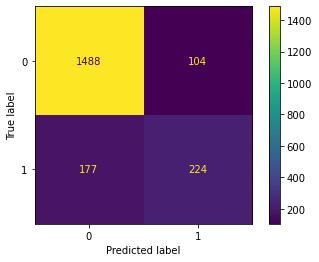

In [326]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [329]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.8590065228299046
Precision: 0.6829268292682927
Recall: 0.5586034912718204


Let’s look at the confusion matrix. This useful visualisation depicts what the model predicted against what the actual cases. We can use this to understand the tradeoff between false positives (top right) and false negatives(bottom left).
In this case the best model has done the following:
- True Positives = 224
- False Negatives = 177 (type II error)
- True Negatives = 1,488
- False Positives = 104 (type I error)

In this exercise, the interest is to predict the leavers of the bank. Out of 401 people (actual = TP +FN) that have left the bank in the test set, the model is able to predict correctly 224 of them. Therefore the recall is 55.8%, ideally we would want this to be higher but given the nature of the data and the problem I would say this is a promising good starting point already. 
Precision (68%) is high in this case, however in this case it is not an important metric as it is acceptale if the 104 predicted leavers(FP) did not actually leave. 

### 3.5 Feature Importance

<AxesSubplot: >

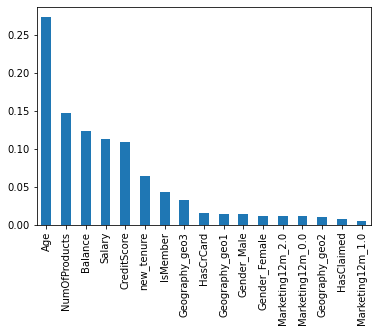

In [328]:
# Create a series containing feature importances from the model and feature names

name_with_prefix = best_rf.named_steps['preprocessor'].get_feature_names_out()
features_names=[name.split('__')[1] for name in name_with_prefix]
feature_importances = best_rf.named_steps['classifier'].feature_importances_

# Feature importance bar chart
(
    pd.Series(feature_importances, index=features_names)
    .sort_values(ascending=False)
    .plot.bar()
)

This tells us that age and the number of products were the biggest predictors in whether the person left the bank.

## 4. Next steps

Other tasks to consider that could improve the model performace include: 

- **Widen the hyperparameters' tunning** Play with other values of the hyperparameters to assess if there are other combinations that can lead to higher recall. 
- **Try other models.** Try other methodologies and see how the results compare. For example, logistic regression, svm or light gbm (if there as a lot of data points)
- **Increase number of cases.** See if the number of cases can be expanded so the data has more than 10k examples
- **Add time/period information and variables.** Get more context of the period of time where this data comes from, which year or season does this come from? is there a particular season where customers are more inclined to leave? Could we add this information or account for seasonality?
- **Add lag variables.** By adding this variables, for example in respect to the customer's balance, it is possible to see how the changes this variable went through in the months previous to leaving the bank. This information is usually a very good predictor of leavers
- **Add information about the customer's bank interactions.** Adding information regarding open banking, savings, customer service interactions, complaints, etc
- **Add consumer's internal segmentation info.** Some banks have their own internal segmentations that summarises the customer's profile and interactions with the bank so this could save some time and add value. 
<br>

## 5. Final thoughts

- The model improved significantly when Age and weighs were added into the model. It went from a recall of approx 34% up to 56%
- There are a few actions that can be tried to see if the model improves
- There some more research to do about some of the variables, like the relationship between Balance and number of products; or the reason behind having 0 Balance and the interactions with the bank. What makes them stay? or what makes them leave? If they don't interact with the bank what's the point of having an acc with 0 Balance?
- It was really fun for me to do and it was nice that the data didn't present a lot of issues, in reality the data cleansing part takes a lot longer and it has a lot more hoops to tackle


**Sources:**<br>
- https://www.datacamp.com/tutorial/random-forests-classifier-python
- https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#
- https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
- The Hundred Page Machine Learning Book; Burkov, Andriy; 7.5.2 Random Forest, page: 84

    